/usr/bin/python3


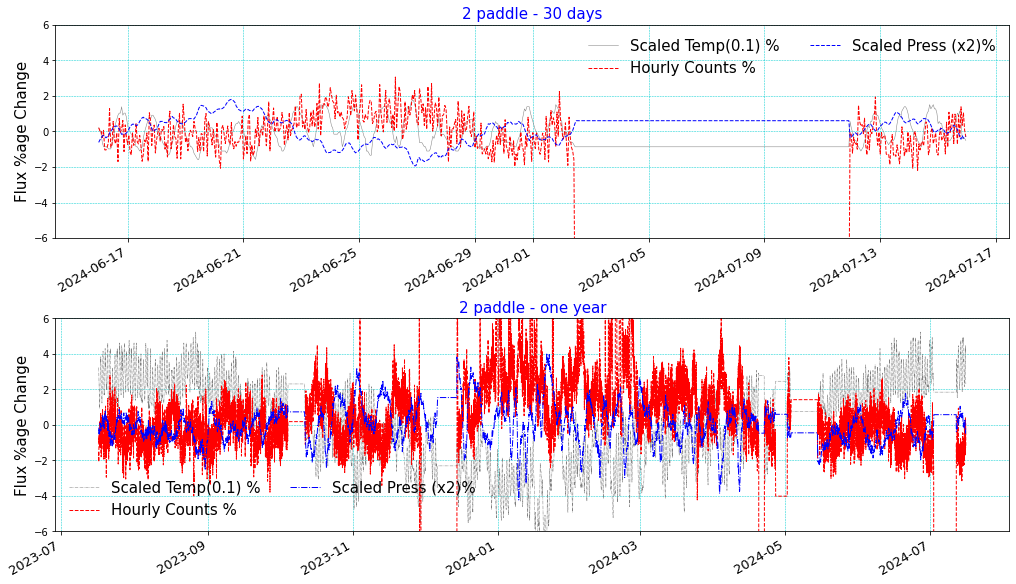

In [4]:
import sys,os,time
print(sys.executable)
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers
from pandas.tseries.frequencies import to_offset # needed to set the time offset to match to the muons DF
import seaborn as sns
from numpy import argmax
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.preprocessing import LabelEncoder

#This code is now capable of merging the last saved data set with new data file (which is updating daily) and saving it, plotting data for the past month and past year
#when the detector power off due to any reason you just need to update the 'fname1' and 'start_datetime' and 'end_datetime'

# three variables to update if you restarted the detector
fname1 = '/home/cosmic/onlineMon/data/2Paddle/2paddle_merged_01_11.csv' # old data file
start_datetime = '2024-07-02 09:00:00' # hour in atlanta time when the detector power off
end_datetime = '2024-07-11 18:00:00' # hour in atlanta time when the detector power back again
file_path = '/home/cosmic/onlineMon/data/2Paddle/2paddle_merged_01_12.csv'


fname2 = '/home/cosmic/onlineMon/data/2Paddle/2paddle.log' #new data file
df_1 = pd.read_csv(fname1, index_col='date')
df_2 = pd.read_csv(fname2, sep='\t',names=["counts"])

df_2 = df_2['counts'].str.split(" ", n = 3,expand = True) #splitting data raw (ex: column 1: 385 column 2: 0 column 3:0 column 4: Wed Oct 11 17:17:30 2023)
dft2 = pd.DataFrame(df_2.values, columns = ["counts","junk1","junk2","date"])# renaming the splited columns
dft2["date"]= pd.to_datetime(dft2['date'], format="%a %b %d %H:%M:%S %Y") # converting date column to datetime data type
dft2['date'] = dft2['date'].dt.tz_localize('America/New_York',ambiguous='infer')#setting current time zone
dft2['date'] = dft2['date'].dt.tz_convert('UTC')#convert time zone to UTC
dft2   = dft2.set_index('date') #making date column the index column
dft2["counts"] = dft2["counts"].apply(pd.to_numeric) #converting counts column data to numeric.
dft2.drop(dft2.columns[[1,2]],axis=1, inplace=True) #removing columns junk1 and junk2

dft2_hourly = dft2.resample('H').sum() #resampling hourly and getting sum
dft2_hourly.drop(dft2_hourly.head(1).index,inplace=True) #dropping the first hour
dft2_hourly.drop(dft2_hourly.tail(1).index,inplace=True) #dropping the last hour

dft2_hourly.loc[dft2_hourly[dft2_hourly['counts'] < 1000].index,'counts']= np.nan
new_index_values = pd.date_range(start=start_datetime, end=end_datetime, freq='H', tz='America/New_York')
new_rows_df = pd.DataFrame(index=new_index_values, columns=dft2_hourly.columns, data=np.nan)
new_rows_df.index = new_rows_df.index.tz_convert('UTC')
updated_df = pd.concat([ new_rows_df, dft2_hourly], axis=0)

dft2_hourly_new = pd.concat([df_1, updated_df],axis=0, ignore_index=False)
dft2_hourly_new.index.name = 'date'

#saving the merged data file with all the data
dft2_hourly_new.to_csv(file_path)


#This part is used to plot the data in two plots for the past 30 days and past year (second part)


now = datetime.now().date()
date_now= now.strftime("%Y-%m-%d")

lastmonth = now - timedelta(days=30)
oneyear = now - timedelta(days=365)

date_30days=lastmonth.strftime("%Y-%m-%d")
date_1year=oneyear.strftime("%Y-%m-%d")

start_date=date_1year
end_date=date_now

# Reading data files for 2 paddle and 4 paddle
df_1 = pd.read_csv(file_path , index_col='date')

#Reading temperature and pressure data for ATL

fPT1    ='mslp_temp.csv' #Loading Pressure Temperature file
df1_PT  = pd.read_csv(fPT1)

#formatting wheather data file

df1_PT.drop(df1_PT[df1_PT['mslp'] == 'M'].index, inplace = True) #removing  rows with M values
df1_PT.drop(df1_PT[df1_PT['tmpf'] == 'M'].index, inplace = True) #removing  rows with M values
df1_PT.dropna(inplace=True)

df1_PT['valid'] = pd.to_datetime(df1_PT['valid'],utc=True) # converting valid column to date time object
df1_PT = df1_PT.set_index('valid') # making valid column the index column
df1_PT = df1_PT.drop(columns=["station"])# dropping the station column

loffset = '-52min'
df1_PT.index = df1_PT.index + to_offset(loffset) #changing time (resetting) ex: 02:52:00 to 02:00:00
df1_PT["mslp"] = df1_PT["mslp"].astype(float) #converting mslp data to floating
df1_PT["tmpf"] = df1_PT["tmpf"].astype(float) #converting tmpf data to floating


#function to merge data file of detector and weather data 

def merge_tables(df, dfpt):
    
    dfpt1 = df1_PT.loc[start_date:end_date].copy()
    df_final= df.loc[start_date:end_date].copy()
    dfpt1.index = pd.to_datetime(dfpt1.index)
    df_final.index = pd.to_datetime(df_final.index)
    merged_df=pd.merge(df_final,dfpt1 , how='inner', left_index=True, right_index=True)
    return merged_df

#function to calculate percentage changes

def calc_percent_change(merged_df):
    
    merged_df["counts_pct"] = ((merged_df['counts'] - merged_df['counts'].mean())/merged_df['counts'].mean())*100 # calculating the hourly count percentage change
    merged_df["press_pct"] = 2*(((merged_df['mslp'] - merged_df['mslp'].mean())/ merged_df['mslp'].mean())*100)
    merged_df["temp_pct"] = ((merged_df['tmpf'] - merged_df['tmpf'].mean())/merged_df['tmpf'].mean())*100 #calculating the percentage change in temp
    merged_df['temp_scaled'] = 0.1*merged_df['temp_pct'] # scale factor
    
    merged_df["delta_cts"]  = (merged_df["counts"]-merged_df["counts"].mean())/merged_df["counts"]
    merged_df["delta_pres"] = (merged_df["mslp"]-merged_df["mslp"].mean())/merged_df["mslp"]


df_1_final= merge_tables(df_1,df1_PT) # merging temp and pres data to counts

#setting mslp and tmpf columns data to NaN which are related to detector power off hours 

df_1_final.loc[df_1_final['counts'].isna(), :] = pd.NA

# makinf final tables
df_1_final_30days   = df_1_final.loc[date_30days:date_now].copy() # table to plot for 30 days
calc_percent_change(df_1_final_30days) #percentage change calculation for 30 days table

df_1_final_oneyear = df_1_final.loc[date_1year:date_now].copy() #table to plot for past year
calc_percent_change(df_1_final_oneyear) #percentage change calculation for past year table


df_1_final_30days ['counts_pct'] = pd.to_numeric(df_1_final_30days ['counts_pct'], errors='coerce')
df_1_final_30days ['temp_scaled'] = pd.to_numeric(df_1_final_30days ['temp_scaled'], errors='coerce')
df_1_final_30days ['press_pct'] = pd.to_numeric(df_1_final_30days ['press_pct'], errors='coerce')
df_1_final_30days ['delta_cts'] = pd.to_numeric(df_1_final_30days ['delta_cts'], errors='coerce')
df_1_final_30days ['delta_pres'] = pd.to_numeric(df_1_final_30days ['delta_pres'], errors='coerce')
df_1_final_30days ['counts'] = pd.to_numeric(df_1_final_30days ['counts'], errors='coerce')
df_1_final_30days ['mslp'] = pd.to_numeric(df_1_final_30days ['mslp'], errors='coerce')

df_1_final_oneyear ['counts_pct'] = pd.to_numeric(df_1_final_oneyear['counts_pct'], errors='coerce')
df_1_final_oneyear ['temp_scaled'] = pd.to_numeric(df_1_final_oneyear['temp_scaled'], errors='coerce')
df_1_final_oneyear ['press_pct'] = pd.to_numeric(df_1_final_oneyear['press_pct'], errors='coerce')


# Replace NaN values with the last valid value
df_1_final_30days ['counts_pct'].fillna(method='ffill', inplace=True)
df_1_final_30days ['temp_scaled'].fillna(method='ffill', inplace=True)
df_1_final_30days ['press_pct'].fillna(method='ffill', inplace=True)

df_1_final_oneyear['counts_pct'].fillna(method='ffill', inplace=True)
df_1_final_oneyear['temp_scaled'].fillna(method='ffill', inplace=True)
df_1_final_oneyear['press_pct'].fillna(method='ffill', inplace=True)




# plotting

fig = plt.figure(figsize=(14, 8),constrained_layout=True)#14,12
gs = fig.add_gridspec(2)
axs = gs.subplots(sharex=False, sharey=False)



axs[0].set_title("2 paddle - 30 days",fontsize=15,color='blue')
axs[0].plot(df_1_final_30days['temp_scaled'],linestyle='-', linewidth=0.5, color='gray', label='Scaled Temp(0.1) %')
axs[0].plot(df_1_final_30days['counts_pct'],linestyle='--', linewidth=1, color='red', label='Hourly Counts %')
axs[0].plot(df_1_final_30days['press_pct'],linestyle='--', linewidth=1, color='blue', label='Scaled Press (x2)%')



axs[1].set_title("2 paddle - one year",fontsize=15,color='blue')
axs[1].plot(df_1_final_oneyear['temp_scaled'],linestyle='-.', linewidth=0.5, color='gray', label='Scaled Temp(0.1) %')
axs[1].plot(df_1_final_oneyear["counts_pct"],linestyle='--', linewidth=1, color='red', label='Hourly Counts %')
axs[1].plot(df_1_final_oneyear["press_pct"],linestyle='-.', linewidth=1, color='blue', label='Scaled Press (x2)%')


axs[0].set_ylabel('Flux %age Change',fontsize=15)
axs[0].set_ylim(-6,6)
axs[0].legend(ncol=2,frameon=False,fontsize=15);
axs[0].tick_params(axis='x', labelsize=13)
axs[0].grid(True, color = 'DarkTurquoise', alpha=1, linestyle = '--', linewidth = 0.5)


axs[1].set_ylabel('Flux %age Change',fontsize=15)
axs[1].set_ylim(-6,6)
axs[1].tick_params(axis='x', labelsize=13)
axs[1].legend(ncol=2,frameon=False,fontsize=15)
axs[1].grid(True, color = 'DarkTurquoise', alpha=1, linestyle = '--', linewidth = 0.5)


plt.setp(axs[1].get_xticklabels(),rotation=30 ,horizontalalignment='right')
plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.savefig('/home/cosmic/onlineMon/images/2paddle_pct_Ch_mostrecent.png')
plt.show()
